# Summary
An explortory analysis of a portfolio of 53165 loans, totalling £707 million, is used to investigate the value and predictors of financial risk.
50 % of the portfolio is fully paid, 11% has been charged off, while 39% is currently being repayed. The potential revenue from all outstanding loans is £289 million.
91 % of commited funding has been recovered, which would increase to 98 % over the next 6 months if all current loans were repaid on schedule.
56 % of the commited funding to charged off loans was recovered. 3.4 % of customers are late on their repayments. The total loss if all late customers were charged offwould be £20 million relative to full repayment.
The combined loss from charged off loans and late loans if they were charged off is 44 % of the total outstanding revenue.

Customers were labeled with a grade and sub-grade, and these show potential for quantifying the risk of charge off. Grade G loans were charged off 28 %, contrasting with Grade A loans were charged off in 4.3 % of cases. 
Five year loans were at 7 % more risk of charge off than three year loans. Loans for small buisnesses stood apart as higher risk. Most loans were for debt consolidation, and these has a similar risk of charge off as the full portfolio. Credit card debt accounted for around 20 % of loans, and was relatively low risk for charge off.
Annual income was lower in customers with charged off loans than fully paid loans. Customers with charged off or late loans had higher average interst rates than full paid loans. DTI, a measure of the customer's affordability of the customers debt, was lower in fully paid loans than charged off or late loans. 

In [1]:
import db_utils as dbu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def get_potential_value(df):
    '''
    Calculate the potential value of a loan if it were fully repaid.

    Parameters:
    ----------
    df: pandas dataframe
        some dataframe to calculate the potential value of
    
    Returns:
    --------
    potential value: float
        the potential value in GBP
    '''
    # P: principle [GBP], r: interest rate, t: term [years]
    P, r, t = df['loan_amount'], 1+df['int_rate']/100, df['term_numeric']/12 
    return ( P * ( r ** t ) ).sum()

def get_loss_breakdown(df, loan_status):
    '''
    Calculate the key statistics for a given dataset and loan status.

    Parameters:
    ----------
    df: pandas dataframe
        some dataframe 
    loan_status: str
        string to match in 'loan_status-simple' column (e.g. 'Current')
    
    Returns:
    --------
    loss_breakdown: dict
        the key stats stored in a dictionary
    '''
    loss_breakdown = {}
    if loan_status:
        df2 = df.loc[df['loan_status-simple']==loan_status]
    else:
        df2 = df
    loss_breakdown['total_loaned'] = df2['funded_amount'].sum()
    loss_breakdown['total_recovered'] = df2['total_payment'].sum()
    loss_breakdown['potential_value'] = get_potential_value(df2)
    if loan_status == 'Charged Off':
        loss_breakdown['extra_recoveries'] = df2['recoveries'].sum()
    else:
        loss_breakdown['extra_recoveries'] = 0
    loss_breakdown['total_lost'] = loss_breakdown['total_loaned'] - (loss_breakdown['total_recovered'] + loss_breakdown['extra_recoveries'])
    loss_breakdown['potential_lost'] = loss_breakdown['potential_value'] - (loss_breakdown['total_recovered'] + loss_breakdown['extra_recoveries'])
    return loss_breakdown

def label_function(val):
    ''' Labels for pi chart.'''
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

def get_pct_loanstatus(df, status):
    ''' Get percentage of a given loan status within a dataframe'''
    N = len(df)
    n = df['loan_status-simple'].value_counts()[status]
    return 100 * n / N
    
def x_pct_of_y(x, y, df):
    ''' Calculate a percentage.

    Parameters:
    ----------
    x, y: str or float
        either column names for dtatframe (if df provided) 
        or numbers (if df passed as None)
    df: pandas dataframe or None
        either pass a dataframe or None
    
    Returns:
    --------
    percentage of x wrt y: float
    '''
    if df is None:
        return 100 * x / y
    else:
        return 100 * df[x].sum() / df[y].sum()

def pct_status(df, column, value, status):
    ''' Return the percentage of a given value within a column with a given loan status.
    
    Parameters:
    ----------
    df: pandas dataframe
    column: str
        column name within df
    value: str
        value within df[column]
    status: str
        value within df['loan_status-simple']
    
    Returns:
    --------
    pct_return: float
        percentage of given loan status within a subset of the dataframe
    len_df: int
        length of subset dataframe
    '''
    df_subset = df.loc[df[column]==value]
    len_df = len(df_subset)
    num_status = df_subset['loan_status-simple'].value_counts()[status]
    pct_return = x_pct_of_y(num_status,len_df,df=None)
    return pct_return, len_df

def pct_status_series(df, column, status):
    ''' Loop through categories within a given column and store stats from pct_status.

    Parameters:
    ----------
    df: pandas dataframe
    column: str
        column name within df
    status: str
        value within df['loan_status-simple']
    
    Returns:
    --------
    pct_stats: pandas dataframe
        pct_status output for each category stored

    '''
    values = []
    cats = []
    n_in_cat = []
    for cg in df[column].cat.categories:
        value, num = pct_status(df,column,cg,status)
        n_in_cat.append(num)
        values.append(value)
        cats.append(cg)
    pct_stats = pd.DataFrame({'pct': values, 'n':n_in_cat}, index=cats)
    return pct_stats 

def plot_bar(height, labels, Ns=None, title=''):
    ''' Plots a bar chart.

    Parameters:
    ----------
    height: list of float
        height of bars
    labels: list of str
        xlabels for bars
    Ns: list of int or None
        number of observations for each bar
    title: str
        plot title
    '''
    plt.figure()
    ax = sns.barplot(x=labels, y=height)
    pos = range(len(height))
    if not Ns is None:
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick], height[tick], Ns[tick], horizontalalignment='center', rotation=300, color='k', size='small')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')

First we read in our clean data, as produced by define_dataframe.py.

In [2]:
df = pd.read_pickle('../data/loan_payments-clean.pkl')
insights = {}

Next, we add a simplified loan status column. The various categories of customers with late payments are grouped together under 'Late', while the various 'Charged Off' and 'Fully Paid' categories are grouped.

In [3]:
transformer = dbu.DataFrameTransform()
transformer.SimpleLoanStatus(df)

In this way we reduce the loan categories to 4.

/var/folders/n4/fgmhzvr967n8z35vtqsh6m2w0000gp/T/ipykernel_43991/2685509323.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('loan_status-simple').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},


<Axes: >

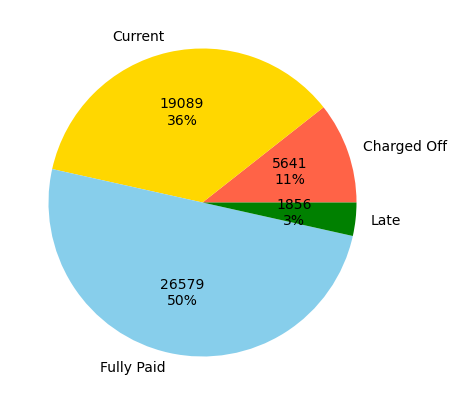

In [4]:
df['loan_status'].value_counts()
print('')
df['loan_status-simple'].value_counts()

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
df.groupby('loan_status-simple').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                  colors=['tomato', 'gold', 'skyblue', 'green', 'magenta'], ax=ax)

We investigate the status of the all the loans for context.
What percentage of loans are recovered against investor funding and total funding?
What percentage would be recovered up to 6 months in future?

In [5]:
insights = {
        'recovered_total': x_pct_of_y('total_payment', 'funded_amount', df),
        'recovered_total_inv': x_pct_of_y('total_payment_inv', 'funded_amount_inv', df)
           }

print('Over the entire dataset, the recovered total is:')
print('> %s %% of total funding' % (round(insights['recovered_total'], 2)))
print('> %s %% of investor funding' % (round(insights['recovered_total_inv'], 2)))
print('')



df['total_payment-est+6'] = np.where(df['loan_status']=='Current', df['total_payment']+df['instalment']*6, df['total_payment'])

insights['recovered_total-est+6'] = x_pct_of_y('total_payment-est+6', 'funded_amount', df)
print('Over the next 6 months, repayment of current loans would generate %s million GBP in revenue.' % ((df['total_payment-est+6'].sum() - df['total_payment'].sum()) * 10**-6))
print('This would increase recovery to %s %% of the total commited.' % (insights['recovered_total-est+6']))




Over the entire dataset, the recovered total is:
> 91.36 % of total funding
> 91.07 % of investor funding

Over the next 6 months, repayment of current loans would generate 50.4934556400001 million GBP in revenue.
This would increase recovery to 98.49932376749727 % of the total commited.


Next, we investigate Charged Off loans specifically. These loans were not fully repaid and no more income is expected from them.

56.471208183600986 % of charged off loans were recovered.
12.724416457418247 % of charged off recoveries were recieved after closure of the loan.


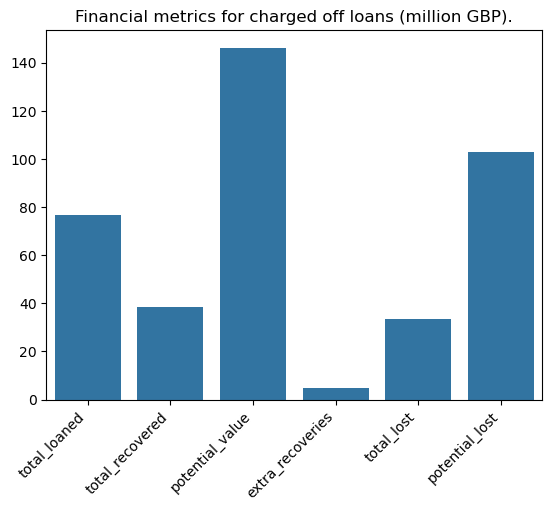

In [6]:
loss_breakdown = {}
df['loan_status'].value_counts()
pct_charged_off = get_pct_loanstatus(df, 'Charged Off')

loss_breakdown['Charged Off'] = get_loss_breakdown(df, 'Charged Off')

insights['recovered_from_charged_off'] = \
    100 * (1 - loss_breakdown['Charged Off']['total_lost']/loss_breakdown['Charged Off']['total_loaned']) 
post_recovery_charged_off = 100 * loss_breakdown['Charged Off']['extra_recoveries']/loss_breakdown['Charged Off']['total_recovered']

print('%s %% of charged off loans were recovered.' % (insights['recovered_from_charged_off']))
print('%s %% of charged off recoveries were recieved after closure of the loan.' % (post_recovery_charged_off))

#plt.bar(x=insights.keys(), height=insights.values())
plot_bar(height=[x * 10**-6 for x in list(loss_breakdown['Charged Off'].values())],
         labels=loss_breakdown['Charged Off'].keys(),
         title='Financial metrics for charged off loans (million GBP).')
#plt.bar(x=loss_breakdown['Charged Off'].keys(),
#        height=loss_breakdown['Charged Off'].values())

Now we want to investigate risk in the loan portfolio. 
Those who are late on their payments may be at greater risk of being Charged Off and we focus on them.

In [7]:
pct_late = get_pct_loanstatus(df, 'Late')
print('%s %% of customers are late on loan repayments.' % (round(pct_late,1)))
loss_breakdown['Late'] = get_loss_breakdown(df, 'Late')

print('The total loss if all those in arrears were charged off would be %s Million GBP.' % (round(loss_breakdown['Late']['total_lost'],2) / 10**6))
print('The loss relative to the value of full repayment for all those in arrears were charged off would be %s Million GBP.' % (round(loss_breakdown['Late']['potential_lost'],2) / 10**6))

3.5 % of customers are late on loan repayments.
The total loss if all those in arrears were charged off would be 2.70575467 Million GBP.
The loss relative to the value of full repayment for all those in arrears were charged off would be 21.30953504 Million GBP.


We can quantify an upper limit on the risks deriving from those late on payments by changing their loan status to Charged Off and quantifying losses.

In [8]:
df_co_late = df.loc[ (df['loan_status-simple']=='Charged Off') | 
                     (df['loan_status-simple']=='Late')]

loss_breakdown['Late->Charged Off'] = get_loss_breakdown(df_co_late, None)

loss_breakdown['Current'] = get_loss_breakdown(df, 'Current')

print('The potential revenue from all outstanding loans is %s Million GBP.' % (loss_breakdown['Current']['potential_lost'] * 10**-6))
print('If all those in arrears were charged off, the total charged off revenue would be %s Million GBP.' % (loss_breakdown['Late->Charged Off']['potential_lost'] * 10**-6))
print('This is %s %% of the total.' % (100 * loss_breakdown['Late->Charged Off']['potential_lost'] / loss_breakdown['Current']['potential_lost']))

The potential revenue from all outstanding loans is 288.67180386971137 Million GBP.
If all those in arrears were charged off, the total charged off revenue would be 129.21991738108105 Million GBP.
This is 44.76360893196307 % of the total.


What factors control the likelihood of charging off loans?
First, we visualise the impact of the categorical variables.
The height of the bars represents the percentage of loans in a given category that were charged off, while the overlying number gives the total customers in that category.
Taking *term*, below, as an example, we see that around 9 % of 36 month loans were charged off whereas around 15 % of 60 month loans were charged off. The sample size is large for both categories (well over 10000 in each), so we expect these percentages to be robust.

*grade* is a good predictor of the likelihood of charge off. Each decrease in *grade* makes charge off more likely. From the best (A) to the worst (G) gradings, we find a 23.6 % increase in the likelihood of charge off. 

*sub_grade* is also clearly related to the likelihood of charge off, though smaller sample sizes introduce extra variability relative to *grade*.

*employment_length* shows no clear trend with likelihood of charge off.

Renters are more likely that mortgage payers to charge off by 2.3 %. Outright owners have a similar charge off probability to renters, which is a surprising result. Further investigation into the causes of relatively high rates of charge off in outright home owners is warranted.

Small buisness related loans stand out as having especially high charge off rates. Over half of the loans were for debt consolidation, and the charge off rates for these are 0.7 % lower than the charg off rates for the entire loan portfolio.

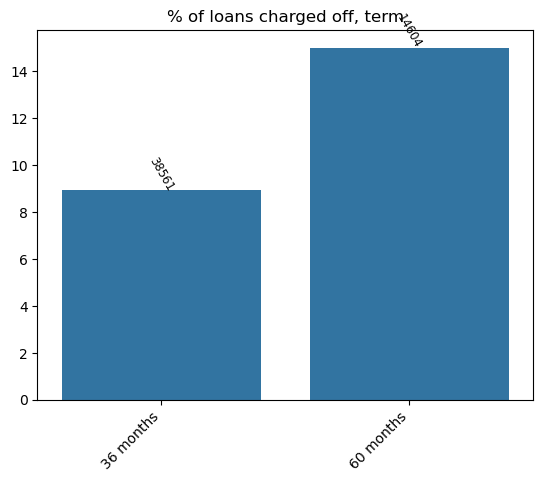

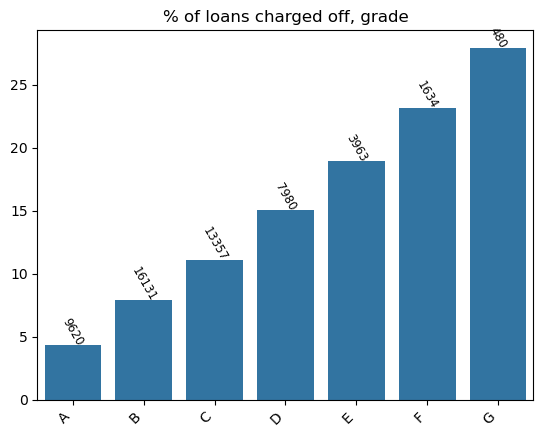

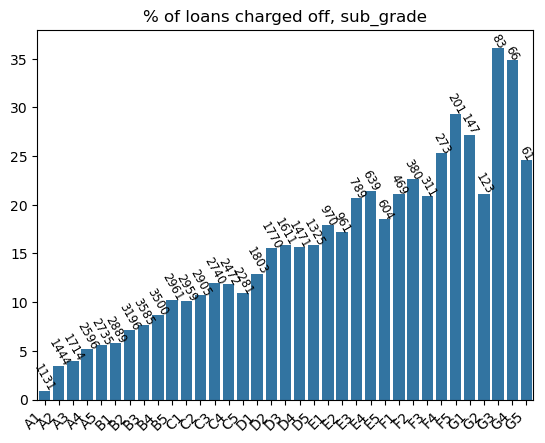

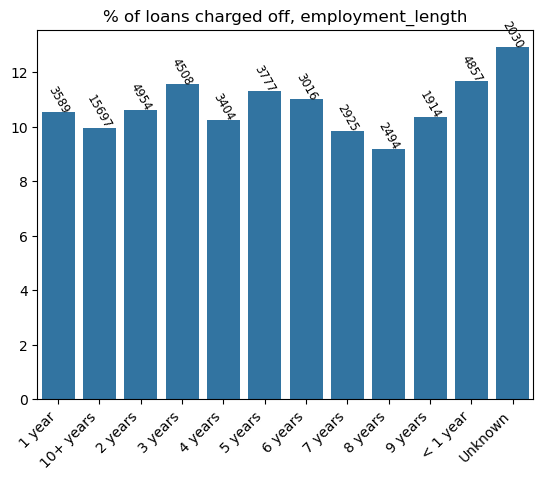

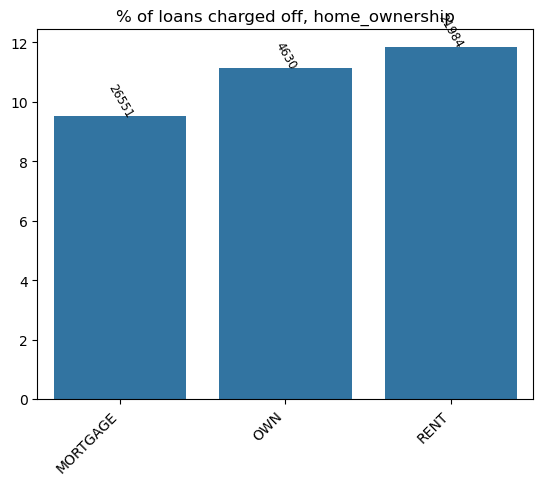

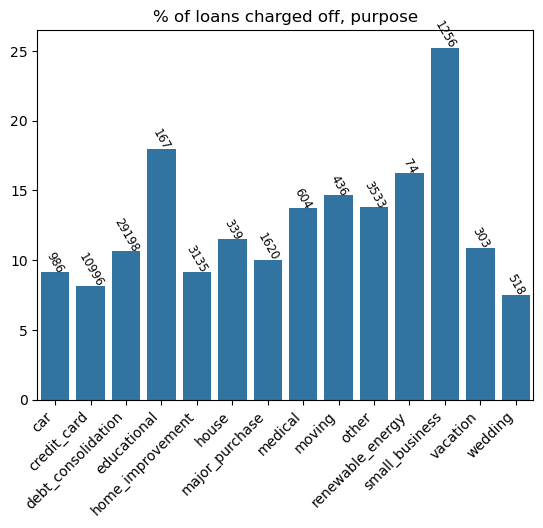

In [9]:
data_frame_info = dbu.DataFrameInfo()
#iscat = data_frame_info.IsCategorical(df)
iscat = ['term','grade','sub_grade','employment_length','home_ownership','purpose']
cat_pct = {}
for cv in iscat:
    cat_pct[cv] = pct_status_series(df, cv, 'Charged Off')
    plot_bar(height=cat_pct[cv]['pct'].values,
             labels=cat_pct[cv].index,
             Ns=cat_pct[cv]['n'].values,
             title='% of loans charged off, ' + cv)

We investigate the numerical variables by visualising their probability density function (PDF). The horizontal axis gives the range of values for a given variable, while the vertical axis gives the probability of that value appearing in the dataset. 
We calculate and plot PDF for subsets of the dataset (*Fully Paid*, *Current*, *Charged Off*, and *Late*).
Differences between *Fully Paid* and *Charged Off* indicate that a given variable could be useful in predicting the likelihood of charge off.
We can also compare the *Late* and *Current* categories to the *Fully Paid* and *Charged Off* categories. For example, If the PDF for *Current* is more similar to *Fully Paid* than *Charged Off* it suggests less risk in the current loans.

*dti* is a measure of the debt burden of the loan relative to the customers total debt. Lower values indicate that repayments on the loan are less burdonsome. For *Fully Paid* loans, *dti* is indeed generally lower than for *Charged Off*. For *Current* and *Late* loans, *dti* is more similar to *Charged Off* than *Fully Paid*.

The *annual_income* is generally lower for *Charged Off* customers. *Fully Paid* and *Current* customers have similar *annual_income*. 

The interest rate is higher in *Charged Off* (median=14.35 %) than in *Fully Paid* (median=12.99 %). Interest rates for *Late* customers are more similar to *Charged Off*, while *Current* customers have rates more similar to *Fully Paid*.

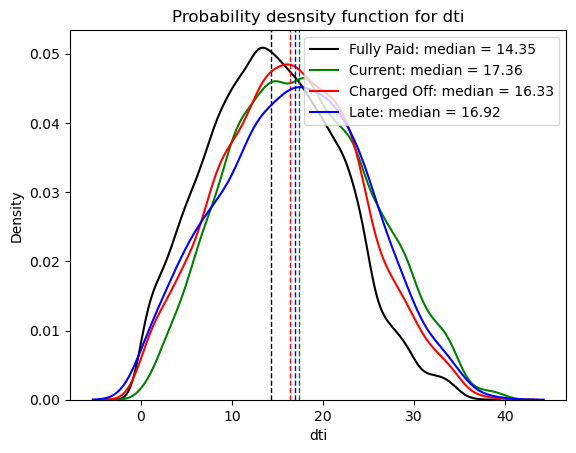

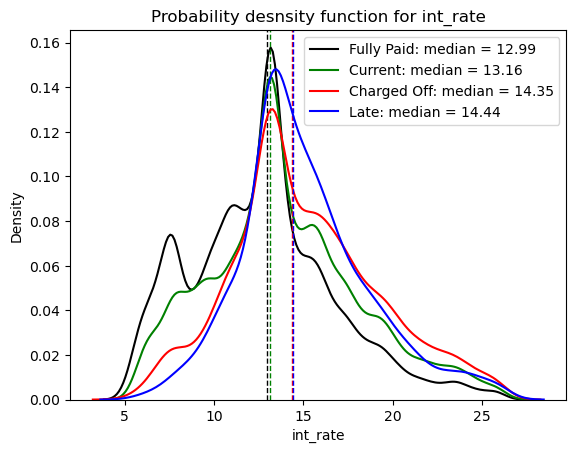

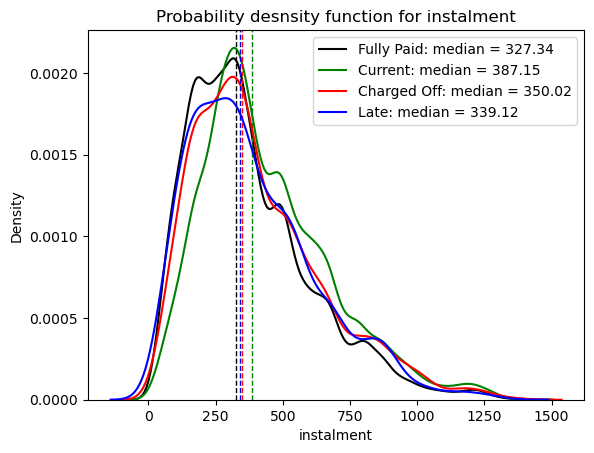

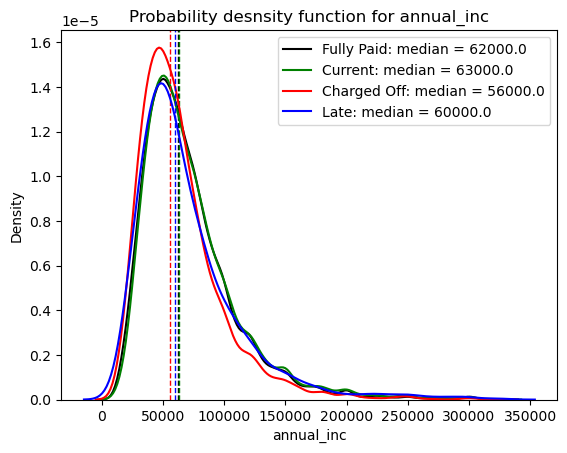

In [10]:
for variable in ['dti','int_rate','instalment','annual_inc']:
    fig, ax = plt.subplots(1,1)
    colours = ['black','green','red','blue']
    statuss = ['Fully Paid', 'Current', 'Charged Off', 'Late']
    for status, colour in zip(statuss, colours):
        to_plot = df[variable].loc[df['loan_status-simple']==status]
        median = to_plot.median()
        label = status + ': median = ' + str(np.round(median,2))
        sns.kdeplot(to_plot, label=label, color=colour)
        plt.axvline(median, color=colour, linestyle='dashed', linewidth=1)
    plt.legend(loc='upper right')
    plt.title('Probability desnsity function for ' + variable)
        #sns.histplot(to_plot, kde=True, element='step', fill=False, stat='density', ax=ax, hue='white')